In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.orm import Code
from aiida.orm import Str, Int, Dict, List
from aiida.engine import calcfunction, WorkChain, ToContext, append_
from aiida.plugins import DataFactory, WorkflowFactory
from itertools import cycle
import os

from aiida.engine import calcfunction, workfunction, submit, run
from aiida.orm import load_code, load_node
from tools.aiida_support import wait_for_node_finished

# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')


In [3]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os
home = expanduser("~")
work_directory = os.path.join(home, 'aiida')
computer_local = get_or_create_local_computer(work_directory, 'localhost')
code = get_or_create_code('alamode.alm_opt',
                          computer_local,
                          '/home/max/Documents/alamode/bin/alm')
code_alm_opt = code
code = get_or_create_code('alamode.anphon',
                          computer_local,
                          '/home/max/Documents/alamode/bin/anphon')
code_anphon = code
code = get_or_create_code('alamode.analyze_phonons',
                          computer_local,
                          '/home/max/Documents/alamode/bin/analyze_phonons')
code_analyze_phonons = code
code_alm_opt, code_anphon, code_analyze_phonons


(<Code: Remote code 'alamode.alm_opt' on localhost, pk: 2434, uuid: 96d86443-33b4-4ded-8101-27900dcefe48>,
 <Code: Remote code 'alamode.anphon' on localhost, pk: 2435, uuid: 5df33ce6-9f81-45f0-b607-1f4459e4f841>,
 <Code: Remote code 'alamode.analyze_phonons' on localhost, pk: 2592, uuid: fe6ad71e-7bbb-4252-80e2-5b43a962258a>)

In [4]:
import json
with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path


{'CWD': 'run35'}


'/home/max/Documents/aiida-alamode_public/example/run35'

In [5]:
from os.path import expanduser
from tools import NodeBank

# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)


In [6]:
g_prefix = nodebank.load('cubic_prefix')

g_norder = nodebank.load(f"{g_prefix.value}_norder")
g_norder, g_prefix


(<Int: uuid: 79b9b510-e505-4397-8faf-21ded8dac26f (pk: 3693) value: 2>,
 <Str: uuid: 365abe8c-3a31-4aa7-b7cf-5da1f911303b (pk: 3694) value: cubic>)

In [7]:
g_cwd = nodebank.load(f"{g_prefix.value}_cwd")  # 保存directory
g_superstructure = nodebank.load("superstructure")  # 長周期構造
g_cwd

<Str: uuid: edaf2272-df44-4202-816b-4e3d50f91415 (pk: 3696) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic>

In [8]:
node = nodebank.load(f'{g_prefix.value}_extract')
g_DFSET = node.outputs.dfset
g_DFSET.get_list()


['# Filename: 0.in, Snapshot: 1',
 '   20.36192357889044    20.39452999456340     0.05729695739195       2.56834074E-02 -1.88569164E-03 -3.68311259E-02',
 '    0.02887308974795     0.04610263273265    -0.05248424220312      -2.16379018E-02 -2.14206581E-02  4.28285435E-02',
 '   20.35574071569599    -0.02541600285407     0.04718779114136       2.48419932E-02  6.23023881E-03 -3.72326885E-02',
 '   -0.04599947088273    -0.00453525331594    -0.05980956351494       3.15134185E-02  3.79991385E-04  2.46976183E-02',
 '   -0.01880932643519     0.05866934510098     0.04379293217288       5.53003948E-03 -2.27454622E-02 -4.36506398E-02',
 '   -0.06561610400325    -0.03669744086417     0.00784400823634       2.16790527E-02  1.47021365E-03  1.10895753E-02',
 '    0.00850158171626     0.05845657951376    20.36188014032293      -1.40525396E-02 -4.55652545E-03  9.42452757E-03',
 '   -0.03106211504299    -0.04211058686052    -0.05454857656542       1.03254365E-02  2.91722898E-02  1.54149596E-02',
 '   2

# alm opt 

In [9]:
g_diag = nodebank.load("factor")
g_primstructure = nodebank.load("primstructure")


In [10]:

g_almprefix = "_".join([g_primstructure.get_formula(), "x".join(
    map(str, g_diag.get_array("factor").reshape(-1))), "cubic"])
g_almprefix = Str(g_almprefix)

g_wd = nodebank.load_or_dump("cubic_almprefix", g_almprefix)  # subdirectory名


debug, node uuid: 09beaa91-fef6-46d7-9718-bcca387bb05a (unstored) value: Si2_2x0x0x0x2x0x0x0x2_cubic
debug, load None
debug, force dump


In [11]:
g_fc2xml = nodebank.load("anphonfile_xml")  # harmonic force constant
g_fc2xml


<SinglefileData: uuid: fff04c7f-db8f-4a58-a79a-8857a2209df0 (pk: 3647)>

In [12]:

code = code_alm_opt

builder = code.get_builder()
builder.structure = g_superstructure
builder.prefix = g_prefix
builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_alm_opt"))  # 保存directory
builder.norder = g_norder
builder.dfset = g_DFSET  # displacementとforce
builder.fc2xml = g_fc2xml  # force constant of the harmonic term

key = f"{g_prefix.value}_alm_opt"


g_alm_opt = nodebank.load_code_or_wait_for_node(key, builder, sec=10)


None
uuid: 44e45523-843a-4528-b016-a29aaa1493d0 (pk: 3978) (aiida.calculations:alamode.alm_opt)
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
True True
0:01:40.725859


In [13]:
g_alm_opt.outputs.results

<Dict: uuid: 3c654f67-297c-4e81-8da1-b7ff32874a3e (pk: 3981)>

In [14]:
g_alm_opt.outputs.input_ANPHON


<SinglefileData: uuid: ead57a8c-c732-4885-b09a-fff01f5f681b (pk: 3982)>

## thermal conductivity


In [15]:
g_primstructure = nodebank.load("primstructure")
g_standardizedstructure = nodebank.load("standardizedstructure")

g_diag = nodebank.load("factor")
g_qmesh = List(list=[5, 5, 5])

g_almprefix = "_".join([g_prefix.value, 'RTA',
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
print(g_almprefix)

g_wd_dos = Str(g_almprefix)
g_wd_dos, g_cwd


cubic_RTA_q5x5x5


(<Str: uuid: cf0b46d4-3c87-4320-a88f-e2efff8be012 (unstored) value: cubic_RTA_q5x5x5>,
 <Str: uuid: edaf2272-df44-4202-816b-4e3d50f91415 (pk: 3696) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic>)

In [16]:
g_property = Str(os.path.join(g_cwd.value, g_almprefix))
g_property


<Str: uuid: b6f4cf7e-c439-4f63-8875-8a6874d13dc5 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic/cubic_RTA_q5x5x5>

In [17]:
code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = Str("RTA")
builder.cwd = g_property
builder.norder = g_norder
builder.fcsxml = g_alm_opt.outputs.input_ANPHON
builder.mode = Str("RTA")
builder.qmesh = g_qmesh

key = "RTA"

g_RTAfuture = nodebank.load_code_or_wait_for_node(key, builder, 10)
g_RTAfuture

None
uuid: b7ae3ab0-681f-4d53-ac01-1c3581d9898d (pk: 3991) (aiida.calculations:alamode.anphon)
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
True True
0:01:20.465189


<CalcJobNode: uuid: b7ae3ab0-681f-4d53-ac01-1c3581d9898d (pk: 3991) (aiida.calculations:alamode.anphon)>

In [18]:
import pandas as pd
import re
import numpy as np
from aiida_alamode.io import load_anphon_kl, load_anphon_kl_spec


In [19]:
# 入力ファイル
g_RTAfuture.outputs.kl_file


<SinglefileData: uuid: 99354b60-b564-4278-8eaf-0b74c7cad018 (pk: 3995)>

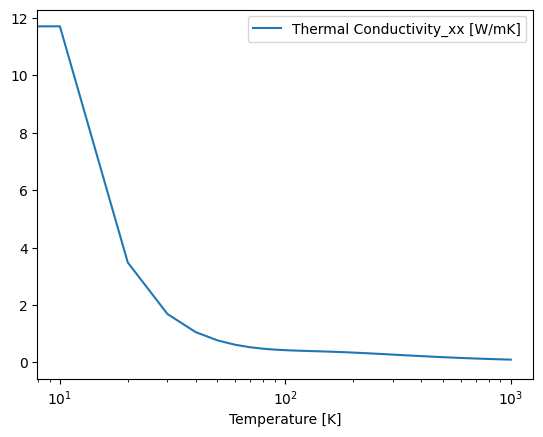

In [20]:
import matplotlib.pyplot as plt
g_df = load_anphon_kl(g_RTAfuture.outputs.kl_file)
g_df.plot(x="Temperature [K]", y="Thermal Conductivity_xx [W/mK]")
plt.xscale("log")


In [21]:
g_RTAfuture.outputs.result_file


<SinglefileData: uuid: 6d5be0d6-0947-4599-83fc-bf9f822a53be (pk: 3994)>

In [22]:
g_almprefix = "_".join([g_prefix.value, 'kappa_boundary',
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_cwd.value, g_almprefix))
g_property, g_wd


(<Str: uuid: 62a306a0-db82-4fea-aef1-ff72b2f23b29 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic/cubic_kappa_boundary_q5x5x5>,
 <Str: uuid: 09beaa91-fef6-46d7-9718-bcca387bb05a (pk: 3973) value: Si2_2x0x0x0x2x0x0x0x2_cubic>)

In [23]:
g_RTAfuture.outputs.result_file.filename


'RTA.result'

In [24]:

code = code_analyze_phonons
key = "ap_kappa"

builder = code.get_builder()
# builder.cwd = g_property
builder.prefix = Str(key)
builder.calc = Str("kappa_boundary")
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"size": 1e+6})

g_ap_kappa = nodebank.load_code_or_wait_for_node(key, builder, 10)


None
uuid: c4802112-5d1d-4ab5-8994-18fa857fe023 (pk: 4001) (aiida.calculations:alamode.analyze_phonons)
wait another 10 sec.
True True
0:00:10.391411


In [25]:
g_ap_kappa.outputs.kappa_boundary_file


<SinglefileData: uuid: ad5522fc-2940-4dac-8ebf-8050e5e3c28b (pk: 4004)>

In [26]:
g_almprefix = "_".join([g_prefix.value, 'tau',
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_cwd.value, g_almprefix))
g_property, g_wd


(<Str: uuid: 4e042726-9786-460c-839d-649ad86aee00 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic/cubic_tau_q5x5x5>,
 <Str: uuid: 09beaa91-fef6-46d7-9718-bcca387bb05a (pk: 3973) value: Si2_2x0x0x0x2x0x0x0x2_cubic>)

In [27]:
code = code_analyze_phonons

builder = code.get_builder()
builder.cwd = g_property
builder.prefix = Str("tau")
builder.calc = Str("tau")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0})

key = "ap_tau"

g_ap_tau = nodebank.load_code_or_wait_for_node(key, builder, 10)


None
uuid: e624de80-fc94-4620-bfd0-4fca22b5cd08 (pk: 4011) (aiida.calculations:alamode.analyze_phonons)
wait another 10 sec.
True True
0:00:10.237494


In [28]:
g_almprefix = "_".join([g_prefix.value, 'cumulative',
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_cwd.value, g_almprefix))
g_property, g_wd


(<Str: uuid: e00507b5-b556-4313-93f1-744ef42e45d7 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic/cubic_cumulative_q5x5x5>,
 <Str: uuid: 09beaa91-fef6-46d7-9718-bcca387bb05a (pk: 3973) value: Si2_2x0x0x0x2x0x0x0x2_cubic>)

In [29]:
code = code_analyze_phonons

builder = code.get_builder()
builder.cwd = g_property
builder.prefix = Str("cumulative")
builder.calc = Str("cumulative")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0, "length": "10000:5"})

key = "ap_cum"
g_ap_cum = nodebank.load_code_or_wait_for_node(key, builder, 10)


None
uuid: bd1a9a2c-9f1c-41bb-b09a-0269e2a3203c (pk: 4021) (aiida.calculations:alamode.analyze_phonons)
wait another 10 sec.
True True
0:00:10.232130


In [30]:
from aiida_alamode.io import parse_analyze_phonons_cumulative

result, splitted_header, values = \
  parse_analyze_phonons_cumulative(g_ap_cum.outputs.cumulative_file)
values


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [5.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [10.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [15.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [20.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [25.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [30.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [35.0,
  0.268747,
  5.70687e-09,
  5.70656e-09,
  5.70687e-09,
  0.268747,
  5.70635e-09,
  5.70656e-09,
  5.70635e-09,
  0.268747],
 [4

In [31]:
values = np.array(values)
splitted_header = splitted_header
df = pd.DataFrame(values, columns=splitted_header)
df


,L [nm],kappa xx [W/mK],kappa xy [W/mK],kappa xz [W/mK],kappa yx [W/mK],kappa yy [W/mK],kappa yz [W/mK],kappa zx [W/mK],kappa zy [W/mK],kappa zz [W/mK]
0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,5.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
2,10.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
3,15.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
4,20.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
...,...,...,...,...,...,...,...,...,...,...
1995,9975.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
1996,9980.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
1997,9985.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747
1998,9990.0,0.268747,5.706870e-09,5.706560e-09,5.706870e-09,0.268747,5.706350e-09,5.706560e-09,5.706350e-09,0.268747


<AxesSubplot:xlabel='L [nm]'>

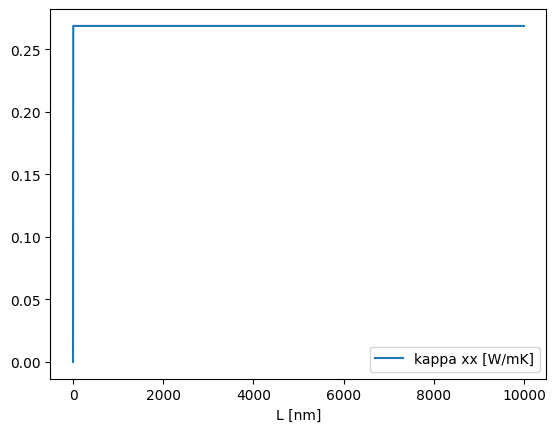

In [32]:
df.plot(x="L [nm]", y='kappa xx [W/mK]')


## anphon spectra

In [33]:
g_almprefix = "_".join([g_prefix.value, 'RTA',
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_cwd.value, g_almprefix))
g_property, g_wd


(<Str: uuid: 174d4895-bb9d-4ae6-8b8c-4dbfafe9e889 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic/cubic_RTA_q5x5x5>,
 <Str: uuid: 09beaa91-fef6-46d7-9718-bcca387bb05a (pk: 3973) value: Si2_2x0x0x0x2x0x0x0x2_cubic>)

In [34]:

code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = Str("RTAspec")
builder.cwd = g_property
builder.norder = g_norder
builder.fcsxml = g_alm_opt.outputs.input_ANPHON
builder.mode = Str("RTA")
builder.kappa_spec = Int(1)  # spectra
builder.qmesh = g_qmesh
eparam = {"EMIN": 0, "EMAX": 550, "DELTA_E": 10.0}
builder.param = Dict(dict={"general": eparam})

key = "RTAspec"
g_RTAspec = nodebank.load_code_or_wait_for_node(key, builder, 10)


None
uuid: c0b31606-7f11-44b6-93e5-6b56c7bdb1fb (pk: 4032) (aiida.calculations:alamode.anphon)
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
True True
0:01:20.487468


In [35]:
g_df = load_anphon_kl_spec(g_RTAspec.outputs.kl_spec_file)


In [36]:
print(np.unique(g_df["Temperature [K]"].values))
g_df_select = g_df[g_df["Temperature [K]"] == 300]


[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.]


<AxesSubplot:xlabel='Frequency [cm^-1]'>

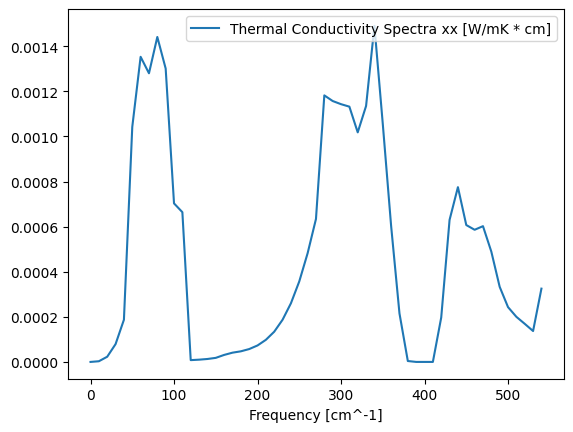

In [37]:
g_df_select.plot(x=g_df.columns[1], y=g_df.columns[2])
